In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.img_processing import resize_img
from heeps.pupil.create_stop import create_stop, dodecagon, hexagon
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

In [2]:
diam_ext_M1 = 37.812                # average M1 diam (from ravc_optim.ipynb)
diam_int_M1 = 10.196
ls_misalign_x = 0#.01
ls_misalign_y = 0#.01

# load useful config params
conf = read_config(npupil=1385)#3291)#10526)#
npupil = conf['npupil']
pupil_img_size = conf['pupil_img_size']
diam_nominal = conf['diam_nominal']
diam_ext_AG = conf['diam_ext']      # all-glass
diam_int_AG = conf['diam_int']
ravc_r_opt = conf['ravc_r']         # cf. ravc optimisation
ravc_t_opt = conf['ravc_t']
seg_width = conf['seg_width']
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
print('npupil=%s, npupil_L=%s, npupil_N=%s'%(npupil, npupil_L, npupil_N))

npupil=3291, npupil_L=285, npupil_N=119


# Check allglass vs fullM1

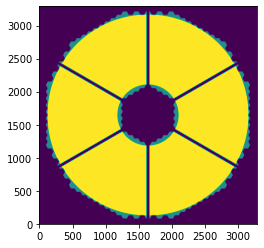

In [3]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
try:
    mask_AG = fits.getdata('eso/mask_AG_%s.fits'%npupil)
except FileNotFoundError:
    mask_AG = resize_img(fits.getdata('eso/mask_allglass.fits')
                       * fits.getdata('eso/SpiderShadow.fits'), npupil)
    fits.writeto('eso/mask_AG_%s.fits'%npupil, mask_AG)
try:
    #mask_M1 = fits.getdata('eso/mask_M1_%s.fits'%npupil)
    mask_M1 = fits.getdata('/Users/cdelacroix/Desktop/data_1_pup_conv.fits')
except FileNotFoundError:
    mask_M1 = resize_img(fits.getdata('eso/mask_fullM1.fits')
                       * fits.getdata('eso/SpiderShadow.fits'), npupil)
    fits.writeto('eso/mask_M1_%s.fits'%npupil, mask_M1)
M1_allglass = np.float32(mask_M1 * (1 + mask_AG)/2)
fits.writeto('eso/mask_M1_allglass_%s.fits'%npupil, M1_allglass, overwrite=True)
plt.imshow(M1_allglass, origin='lower');

diam_dodecagon = 36.8765
diam_hexagon = 10.0529


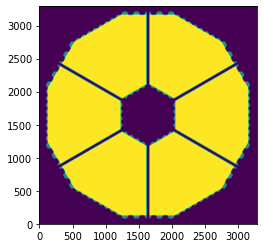

In [4]:
# a bit of geometry to find the dodecagon and hexagon edges ...
alpha = np.arcsin(seg_width/diam_ext_AG)
beta = np.pi/6 - np.arcsin(seg_width*np.sin(np.pi/6)/diam_int_AG)
diam_dodecagon = np.cos(alpha)*diam_ext_AG
diam_hexagon = np.cos(beta)*diam_int_AG
print('diam_dodecagon = %s\ndiam_hexagon = %s'%(np.round(diam_dodecagon, 4), 
    np.round(diam_hexagon, 4)))
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
M1_dodhex = np.float32(mask_M1 * (2 - dodecagon(r_ext, npupil) - hexagon(r_int, npupil))/2)
fits.writeto('eso/mask_M1_dodhex_%s.fits'%npupil, M1_dodhex, overwrite=True)
plt.imshow(M1_dodhex, origin='lower');

# L-band RAVC
### Calculate RAVC parameters (wrt all-glass diameters)

In [5]:
# all-glass parameters
r_obstr_AG = diam_int_AG/diam_ext_AG
ravc_t_AG = 1 - (r_obstr_AG**2 + r_obstr_AG*np.sqrt(r_obstr_AG**2 + 8))/4
ravc_r_AG = r_obstr_AG/np.sqrt(1 - ravc_t_AG)
diam_ravc_AG = ravc_r_AG*diam_ext_AG
print('diam_ravc_AG = %s (t=%s, r=%s)'%(np.round(diam_ravc_AG, 4),
    np.round(ravc_t_AG, 2), np.round(ravc_r_AG, 2)))
# full-M1 parameters
r_obstr_M1 = diam_int_M1/diam_ext_M1
ravc_t_M1 = 1 - (r_obstr_M1**2 + r_obstr_M1*np.sqrt(r_obstr_M1**2 + 8))/4
ravc_r_M1 = r_obstr_M1/np.sqrt(1 - ravc_t_M1) * (diam_ext_M1/diam_ext_AG)
diam_ravc_M1 = ravc_r_M1*diam_ext_AG
print('diam_ravc_M1 = %s (t=%s, r=%s)'%(np.round(diam_ravc_M1, 4),
    np.round(ravc_t_M1, 2), np.round(ravc_r_M1, 2)))
# optimal parameters (cf. ravc optimisation)
diam_ravc_opt = ravc_r_opt*diam_ext_AG
print('diam_ravc_opt = %s (t=%s, r=%s)'%(np.round(diam_ravc_opt, 4), 
    np.round(ravc_t_opt, 3), np.round(ravc_r_opt, 3)))

diam_ravc_AG = 22.9287 (t=0.76, r=0.62)
diam_ravc_M1 = 22.2647 (t=0.79, r=0.6)
diam_ravc_opt = 19.1537 (t=0.791, r=0.519)


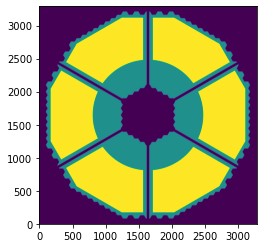

In [6]:
stop_params = (0.0291, 0.0291, 0.0317)
mask = create_stop(diam_ext_AG, diam_ravc_opt, *stop_params, circ_ext=False, **conf)
fits.writeto('ls_RAVC_L_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
    (npupil_L, *stop_params), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 * (1 + mask)/2 , origin='lower');

# L-band CVC

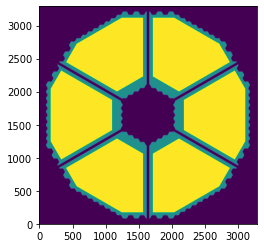

In [7]:
stop_params = (0.0291, 0.08, 0.0317)
mask = create_stop(diam_ext_AG, diam_int_AG, *stop_params, 
    circ_ext=False, circ_int=False, **conf)
fits.writeto('ls_CVC_L_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
    (npupil_L, *stop_params), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 * (1 + mask)/2, origin='lower');

# N2-band CVC

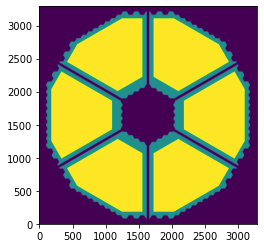

In [8]:
stop_params = (0.0356, 0.08, 0.0383)
mask = create_stop(diam_ext_AG, diam_int_AG, *stop_params, **conf)
fits.writeto('ls_CVC_N2_%s_dRext=%s_dRint=%s_dRspi=%s_circ.fits'%
    (npupil_N, *stop_params), resize_img(mask, npupil_N), overwrite=True)
mask = create_stop(diam_ext_AG, diam_int_AG, *stop_params, 
    circ_ext=False, circ_int=False, **conf)
fits.writeto('ls_CVC_N2_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
    (npupil_N, *stop_params), resize_img(mask, npupil_N), overwrite=True)
plt.imshow(mask_M1 * (1 + mask)/2, origin='lower');

# L-band CLC

In [9]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.848, 4)
ls_dRint = np.round(0.34 - diam_int_AG/diam_nominal, 4)
stop_params = (ls_dRext, ls_dRint, 0.0317)
mask = create_stop(diam_ext_AG, diam_int_AG, *stop_params, **conf)
fits.writeto('ls_CLC_L_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
    (npupil_L, *stop_params), resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 * (1 + mask)/2, origin='lower');

# N2-band CLC

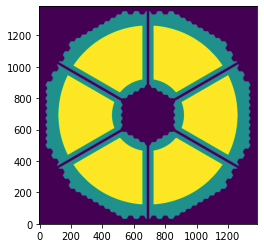

In [ ]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.853, 4)
ls_dRint = np.round(0.342 - diam_int_AG/diam_nominal, 4)
stop_params = (ls_dRext, ls_dRint, 0.0383)
mask = create_stop(diam_ext_AG, diam_int_AG, *stop_params, **conf)
fits.writeto('ls_CLC_N2_%s_dRext=%s_dRint=%s_dRspi=%s.fits'%
    (npupil_N, *stop_params), resize_img(mask, npupil_N), overwrite=True)
plt.imshow(mask_M1 * (1 + mask)/2, origin='lower');